In [1]:
!pip install fsspec
!pip install pandas_ta
import fsspec
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=b913c5e99e90c4bc550374d0413f7d40153f68c5c13d42e5973fe12fd3a9ba78
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


# Data

## Data Load

In [2]:
destination = Path("data")
destination.mkdir(exist_ok=True, parents=True)
fs = fsspec.filesystem("github", org="lorenzovecchietti", repo="FinanceAI")
fs.get(fs.ls("data/"), destination.as_posix())

In [3]:
def concatenate_text_files(folder_path, output_file):
    # List to hold the names of text files
    text_files = sorted([f for f in os.listdir(folder_path) if f.startswith("SPY")])

    with open(output_file, 'w', encoding='utf-8') as outfile:
        for filename in text_files:
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as infile:
                outfile.write(infile.read())  # Add newline for separation

# Example usage
folder_path = 'data'  # Replace with your folder path
output_file = 'data/1_min_SPY_2008-2021.csv'  # Output file name
concatenate_text_files(folder_path, output_file)

In [4]:
import pandas as pd
df=pd.read_csv(output_file, header=1, dtype={"Open":np.float32, "High":np.float32, "Low":np.float32, "Close":np.float32, "Volume":np.uint8,"Bars":np.uint8, "Average":np.float32}, names=["","DateTime Stamp", "Open", "High", "Low", "Close", "Volume","Bars", "Average"],usecols=[1,2,3,4,5,6,7,8], index_col=0, parse_dates=True, date_format='%Y%m%d  %H:%M:%S', sep=",")
print(df.head())

                          Open       High        Low      Close  Volume  Bars  \
DateTime Stamp                                                                  
2009-05-22 07:31:00  89.379997  89.529999  89.370003  89.500000     216   146   
2009-05-22 07:32:00  89.510002  89.540001  89.480003  89.489998      21   160   
2009-05-22 07:33:00  89.489998  89.489998  89.309998  89.339996     167   216   
2009-05-22 07:34:00  89.330002  89.459999  89.330002  89.389999       3    77   
2009-05-22 07:35:00  89.379997  89.410004  89.169998  89.180000      98    62   

                       Average  
DateTime Stamp                  
2009-05-22 07:31:00  89.468002  
2009-05-22 07:32:00  89.515999  
2009-05-22 07:33:00  89.386002  
2009-05-22 07:34:00  89.378998  
2009-05-22 07:35:00  89.273003  


## Clean Data

In [5]:
df.sort_index(inplace=True) # sort by date
df.drop_duplicates(keep='first', inplace=True) # Remove duplicate rows

## Check data

Check if there is any missing data

In [6]:
# Calculate the difference in minutes
diff_series = df.index.to_series().diff().dt.total_seconds() / 60

# Create a boolean mask for validity
validity_series = (diff_series == 1) | (df.index != df.index.to_series().shift(1))

# Convert to a Series with the same index
validity_series = pd.Series(validity_series.values, index=df.index)

# Print invalid entries
print(validity_series[~validity_series])

Series([], dtype: bool)


Print data description and plot

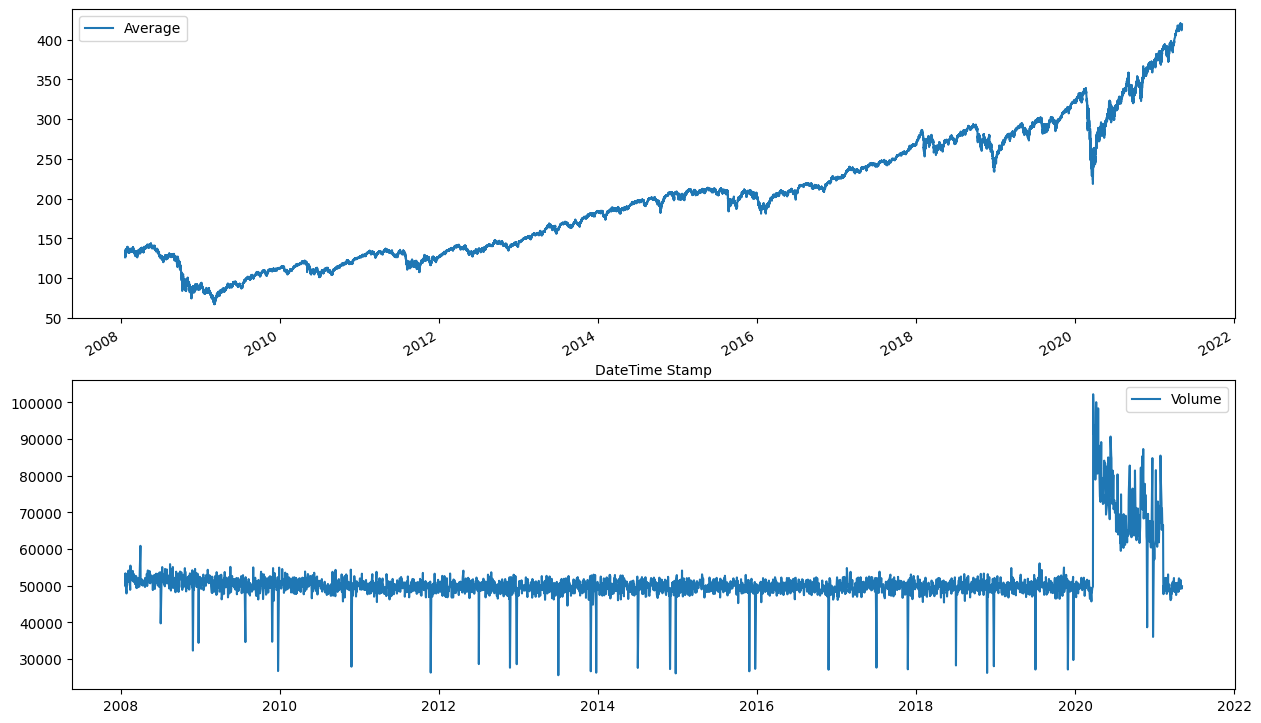

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
df.plot(y=['Average'], ax=axs[0])
df.groupby(by=df.index.date).sum().plot(y=['Volume'], ax=axs[1])
fig.show()

## Resample data and add labeling

Resample data on the 5 minutes timeframe.

In [8]:
df=df.resample('5min').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', "Average": "mean", 'Volume': 'sum'})

In [9]:
df.dropna(inplace=True)

In [10]:
df["returns"] = df['Close'].shift(-1)/df['Close'] # 5 mins
df["volatility"] = df["returns"].rolling(window=10).std() * np.sqrt(10) # moltiplico sqrt?

In [11]:
df["volatility"].head(100)

,volatility
DateTime Stamp,
2008-01-22 07:30:00,NaN
2008-01-22 07:35:00,NaN
2008-01-22 07:40:00,NaN
2008-01-22 07:45:00,NaN
2008-01-22 07:50:00,NaN
...,...
2008-01-23 08:40:00,0.011390
2008-01-23 08:45:00,0.012306
2008-01-23 08:50:00,0.012629


In [12]:
K = 0.55  # coefficiente

label = np.ones(len(df))
label[(df["returns"] > (1 + K * df["volatility"]))] = 2
label[(df["returns"] < (1 - K * df["volatility"]))] = 0
label[df["returns"].isna() | df["volatility"].isna()] = np.nan

df["Up"]=label==2
df["Flat"]=label==1
df["Down"]=label==0
print(df.head(500))

                           Open        High         Low       Close  \
DateTime Stamp                                                        
2008-01-22 07:30:00  126.449997  127.180000  126.000000  126.779999   
2008-01-22 07:35:00  126.800003  127.889999  126.120003  127.650002   
2008-01-22 07:40:00  127.580002  128.259995  127.000000  128.100006   
2008-01-22 07:45:00  128.080002  129.300003  128.029999  129.029999   
2008-01-22 07:50:00  129.020004  129.860001  128.919998  129.250000   
...                         ...         ...         ...         ...   
2008-01-30 08:15:00  135.910004  136.000000  135.809998  135.960007   
2008-01-30 08:20:00  135.960007  136.130005  135.960007  136.039993   
2008-01-30 08:25:00  136.050003  136.070007  135.949997  135.970001   
2008-01-30 08:30:00  135.979996  135.990005  135.830002  135.889999   
2008-01-30 08:35:00  135.889999  135.979996  135.809998  135.860001   

                        Average  Volume   returns  volatility     Up   Flat 

In [13]:
df.dropna(inplace=True)
labels = df[["Up", "Flat", "Down"]]
df.drop(columns=["volatility", "returns", "Up", "Flat", "Down"], inplace=True)

In [14]:
print(labels.head(1500))
print(f"Directional labels : {((labels['Up'] | labels['Down'])).sum()/len(labels)}")

                        Up   Flat   Down
DateTime Stamp                          
2008-01-22 08:15:00  False   True  False
2008-01-22 08:20:00  False   True  False
2008-01-22 08:25:00  False   True  False
2008-01-22 08:30:00  False   True  False
2008-01-22 08:35:00  False   True  False
...                    ...    ...    ...
2008-02-15 11:20:00  False   True  False
2008-02-15 11:25:00  False   True  False
2008-02-15 11:30:00  False   True  False
2008-02-15 11:35:00   True  False  False
2008-02-15 11:40:00  False   True  False

[1500 rows x 3 columns]
Directional labels : 0.08778283073674938


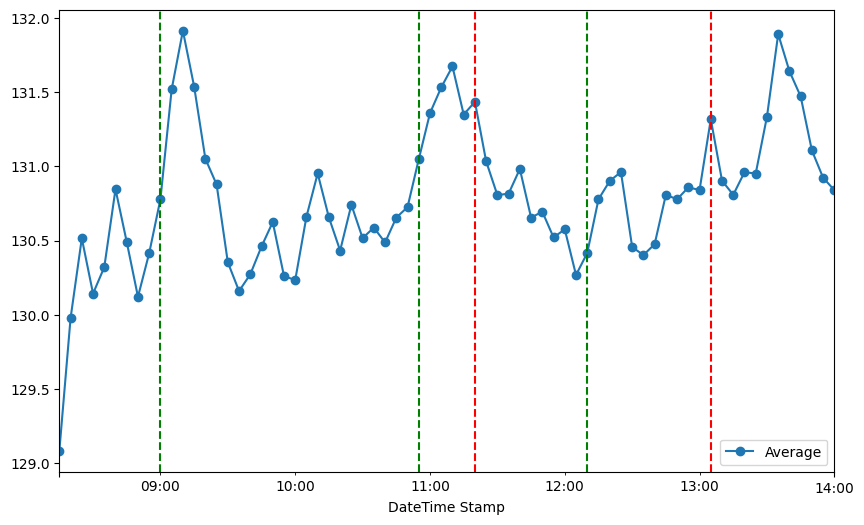

In [15]:
n=70
fig, ax = plt.subplots(figsize=(10, 6))
df.head(n).plot(y=['Average'], ax=ax, marker="o")
for index, row in labels.head(n).iterrows():
    if row['Up']:
        ax.axvline(x=row.name, color='green', linestyle='--')
    elif row['Down']:
        ax.axvline(x=row.name, color='red', linestyle='--')

In [16]:
from torch import nn

class CDT1DCNN(nn.Module):
  def __init__(self):
    super().__init__()
    ks1=(1,4)
    ks2=(1,3)
    ks3=(1,2)
    self.conv1 = nn.Conv2d(
      in_channels=1,
      out_channels=32,
      kernel_size=ks1,
      stride=1,
      padding=(0,1),
      padding_mode='replicate'
    )
    self.max_pooling1 = nn.MaxPool2d(kernel_size=ks1, stride=4,      padding=(0,1),)
    self.conv2 = nn.Conv2d(
      in_channels=32,
      out_channels=64,
      kernel_size=ks2,
      stride=1,
      padding=(0,1),
      padding_mode='replicate'
    )
    self.max_pooling2 = nn.MaxPool2d(kernel_size=ks2, stride=3,       padding=(0,1),)
    self.conv3 = nn.Conv2d(
      in_channels=64,
      out_channels=128,
      kernel_size=ks3,
      stride=1,
      padding=(0,1),
      padding_mode='replicate'
    )
    self.max_pooling3 = nn.MaxPool2d(kernel_size=ks3, stride=2)
    self.fc1=nn.Linear(128, 1000)
    self.fc2 = nn.Linear(1000, 500)
    self.sm = nn.Softmax(dim=0)
    self.fc3 = nn.Linear(in_features=500, out_features=3)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, x):
      x = self.relu(self.conv1(x))
      x = self.max_pooling1(x)
      x = self.relu(self.conv2(x))
      x = self.max_pooling2(x)
      x = self.relu(self.conv3(x))
      x = self.max_pooling3(x)
      x = x.view(x.size(0), 128)
      x = self.relu(self.fc1(x))
      x = self.dropout(x)
      x = self.relu(self.fc2(x))
      x = self.dropout(x)
      x = self.fc3(x)
      x = self.sm(x)
      return x

model = CDT1DCNN()

Create labels

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Supponiamo che tu abbia un DataLoader chiamato train_loader
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = torch.tensor(df.values, device=device)
labels = torch.tensor(labels.astype("int").values, device=device)
data=data.T
labels=labels.T

In [18]:
print(labels.shape)
print(data.shape)

torch.Size([3, 286081])
torch.Size([6, 286081])


In [19]:
# Creare una maschera per le righe in cui la colonna 0 o 2 è uguale a 1
mask = (labels[0,:] == 1) | (labels[2,:] == 1)

# Ottenere gli indici delle righe che soddisfano la condizione
indices = torch.nonzero(mask).squeeze()

# Inizializzare una lista per memorizzare i dati finali
result_data = []

# Estrarre i dati per ogni indice trovato
for idx in indices:
    start_index = idx.item() - 23  # Assicurarsi di non uscire dai limiti
    if start_index < 0:
        continue
    else:
      relevant_data = data[:, start_index:idx + 1]  # Estrarre i dati rilevanti
      result_data.append((labels[:, idx], relevant_data))

# Convertire la lista in un formato più gestibile se necessario
final_labels = torch.stack([item[0] for item in result_data])
final_data = torch.stack([item[1] for item in result_data])

print(final_labels.shape)
print(final_data.shape)

torch.Size([25112, 3])
torch.Size([25112, 6, 24])


In [20]:
dataset = TensorDataset(final_data,final_labels)

In [21]:
# Dimensioni del train e test set
train_size = int(0.8 * len(dataset))  # 80% per il training
test_size = len(dataset) - train_size  # Rimanente per il test

# Suddividere i dati
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creare DataLoader per il training e il test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
# Sposta il modello sul dispositivo (GPU o CPU)
model.to(device)

# Ciclo di addestramento
for epoch in range(num_epochs):
    model.train()  # Imposta il modello in modalità training
    for batch_idx, (data, target) in enumerate(train_loader):  # Usa train_loader
        data, target = data.to(device), target.to(device)  # Sposta i dati e i target sul dispositivo

        optimizer.zero_grad()  # Azzerare i gradienti
        data=data.float().unsqueeze(1) # conv2d expects N, Ch, H, W
        output = model(data)  # Passa i dati attraverso il modello
        loss = criterion(output, target.float())  # Calcola la loss
        loss.backward()  # Calcola i gradienti
        optimizer.step()  # Aggiorna i pesi

        # Stampa la loss ogni 100 batch
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

print("Training completed!")

Epoch 1/10, Batch 0/628, Loss: 1.1016
Epoch 1/10, Batch 100/628, Loss: 1.1194
Epoch 1/10, Batch 200/628, Loss: 1.0941
Epoch 1/10, Batch 300/628, Loss: 1.0989
Epoch 1/10, Batch 400/628, Loss: 1.0987
Epoch 1/10, Batch 500/628, Loss: 1.0988
Epoch 1/10, Batch 600/628, Loss: 1.0984
Epoch 2/10, Batch 0/628, Loss: 1.0985
Epoch 2/10, Batch 100/628, Loss: 1.0985
Epoch 2/10, Batch 200/628, Loss: 1.0992
Epoch 2/10, Batch 300/628, Loss: 1.0991
Epoch 2/10, Batch 400/628, Loss: 1.0980
Epoch 2/10, Batch 500/628, Loss: 1.0988
Epoch 2/10, Batch 600/628, Loss: 1.0990
Epoch 3/10, Batch 0/628, Loss: 1.0991
Epoch 3/10, Batch 100/628, Loss: 1.0989
Epoch 3/10, Batch 200/628, Loss: 1.0982
Epoch 3/10, Batch 300/628, Loss: 1.0982
Epoch 3/10, Batch 400/628, Loss: 1.0989
Epoch 3/10, Batch 500/628, Loss: 1.0989
Epoch 3/10, Batch 600/628, Loss: 1.0982
Epoch 4/10, Batch 0/628, Loss: 1.0982
Epoch 4/10, Batch 100/628, Loss: 1.0988
Epoch 4/10, Batch 200/628, Loss: 1.0984
Epoch 4/10, Batch 300/628, Loss: 1.0984
Epoch 4/